# Learning models from data: Mauna Loa CO$_2$ record

## Motivation: Climate Change

> _The climate emergency is one of the most pressing issues of our time. At this pivotal moment, the decisions and actions we take today will reverberate beyond our own borders and lifetimes._ -- [UBC Climate Emergency Engagement](https://climateemergency.ubc.ca/)

Carbon Dioxide (CO$_2$) is a greenhouse gas, and significant contributor to the warming of the climate. It is an important input into climate models, which we use to make predictions about possible future climate scenarios, and sometimes to make policy decisions, including carbon taxes. 

**Question:** Based on historical CO$_2$ data, can we predict what CO$_2$ concentrations will be in the future? 

## Learning Goals
- explore the idea of "learning": building a model from data that lets us make predictions 
- introduce the principles of linear regression, a simple, but powerful method for estimating a linear model of data
- explore the impact of outliers in data on the model 
- discuss the limitations of models

## Context

Scripps institute of Oceanography has a research station at Mauna Loa in Hawaii where they have been measuring atmospheric CO$_2$ since 1958. The data we will focus on are the seasonally adjusted data. 

<img src="https://scrippsco2.ucsd.edu/assets/images/mlo_station_map.png" align="center">

**Data Source**

C. D. Keeling, S. C. Piper, R. B. Bacastow, M. Wahlen, T. P. Whorf, M. Heimann, and  H. A. Meijer, Exchanges of atmospheric CO2 and 13CO2 with the terrestrial biosphere and  oceans from 1978 to 2000.  I. Global aspects, SIO Reference Series, No. 01-06, Scripps  Institution of Oceanography, San Diego, 88 pages, 2001. https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html   

## Running the notebook
- Each block of code can be run with `shift` + `enter` or from the menu with `Cell` + `Run Cells`
- If you need to restart the notebook, go to the menu: `Kernel` + `Restart`. 

## Import the python packages we use in this lesson 

These are standard packages in python, 
- `numpy` is the numerical array package in python
- `scipy.stats` is what we will use to estimate a linear model 
- `matplotlib` has tools for plotting
- `ipywidgets` lets us connect interactive components like slide bars and toggle buttons to the code

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import ipywidgets as widgets

# set a larger font size for viewing 
from matplotlib import rcParams
rcParams["font.size"] = 14

## Load the data

In [2]:
co2_data = np.load("mauna_loa_data.npz")
dates = co2_data["dates"]
co2 = co2_data["co2"]

In [3]:
print(
    f"The first year in the data is {int(dates.min())} "
    f"and the last year in the data set is {int(dates.max())}." 
)

The first year in the data is 1958 and the last year in the data set is 2020.


## Define some helper functions for fetching data

- `get_data_between`  : fetches the seasonally adjusted CO$_2$ data from Mauna Loa between `year_min` and `year_max`

- `plot_co2_data` plots the data between `year_min` and `year_max`

In [4]:
def get_data_between(year_min=1958, year_max=2020, data_type="seasonally adjusted"):
    """
    A function to fetch data between year_min and year_max  
    """
        
    # find the data between the minimimum and maximum years
    indices = (dates >= year_min) & (dates <= year_max) 
    
    return dates[indices], co2[indices]
    

In [5]:
def plot_co2_data(dates, data, ax=None):
    """
    A function that we can use to plot data between year_min and year_max
    """
    
    # create a figure if one isn't supplied
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        
    # plot data
    ax.plot(dates, data, '.',  ms=8)
    ax.grid()
    ax.set_xlabel(f"Year")
    ax.set_ylabel(f"Seasonally adjusted CO$_2$ [ppm]")

## Plot the whole data set

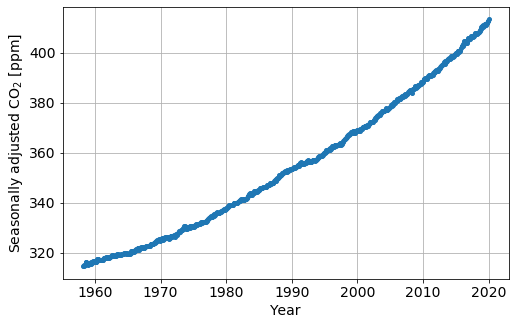

In [6]:
plot_co2_data(dates, co2)

## Focus on the first 5 years

**Question:** If the trend between 1958 and 1963 continues, what would we expect the CO$_2$ concentration to be in January, 2022?  

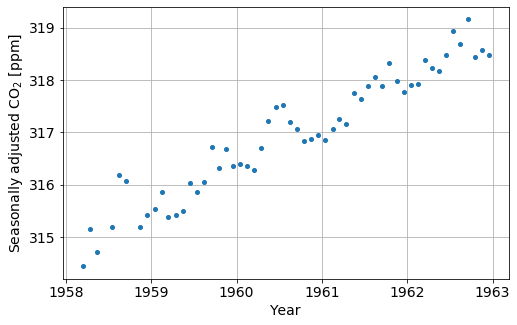

In [7]:
early_year = 1963
dates_before_early_year, co2_before_early_year = get_data_between(year_max=early_year)
plot_co2_data(dates_before_early_year, co2_before_early_year)

### Part 1: The "eyeball" norm 

- using the widgets below, estimate a slope and intercept of a line that fits the data
- the `slope` indicates the rate of CO$_2$ accumulation per year
- the `intercept` is the estimated concentration of CO$_2$ at the first point we consider

In [8]:
def add_line(dates, slope, intercept, ax=None, label=None):
    """
    A function to add a line to a plot
    """
    
    # create a figure if one isn't supplied
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    y = slope * (dates - dates.min()) + intercept
    ax.plot(dates, y, label=label)

In [9]:
def widget_fit_co2_data(slope, intercept, year_min=1958, year_max=2020):
    """
    This function creates an interactive widget where we can fit a curve to data
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    dates_in_range, data_in_range = get_data_between(
        year_min=year_min, year_max=year_max
    )
    plot_co2_data(dates_in_range, data_in_range, ax=ax)
    ax.set_ylim([data_in_range.min()-1, data_in_range.max()+1])
    add_line(dates_in_range, slope, intercept, ax=ax)

In [10]:
w_early_year = widgets.interactive(
    widget_fit_co2_data, 
    slope=widgets.FloatSlider(min=0, max=5, step=0.1, value=2),
    intercept=widgets.FloatSlider(min=co2_before_early_year.min()-1, max=co2_before_early_year.max()+1, step=0.25),
    year_min=widgets.fixed(1958),
    year_max=widgets.fixed(early_year),
)
w_early_year

interactive(children=(FloatSlider(value=2.0, description='slope', max=5.0), FloatSlider(value=313.44, descript…

### Discuss with your neighbour

- What are the features of a "good fit"? 

### Make a prediction 

Based on your estimated slope and intercept values what will the CO$_2$ concentration be in January 2030

In [11]:
predict_year = 2030

In [12]:
def predict_co2(slope, intercept, initial_date, prediction_date):
    """
    based on an estimated slope, and intercept use a linear 
    model to predict CO2 concentration
    """
    return slope * (prediction_date-initial_date) + intercept

The following lines of code grab the value of the slope and intercept from the widget above. 

In [13]:
eyeball_slope_early = w_early_year.children[0].value
eyeball_intercept_early = w_early_year.children[1].value

Choose a year to make a prediction about and estimate CO$_2$ concentration. 

In [14]:
prediction_eyeball_early = predict_co2(
    eyeball_slope_early,
    eyeball_intercept_early,
    dates_before_early_year.min(),
    predict_year
)

print(
    f"Predicted CO2 in {predict_year}: {prediction_eyeball_early:1.2f} [ppm]"
)

Predicted CO2 in 2030: 457.03 [ppm]


### Part 2: Using least squares

In a linear regression (a least-squares problem with one dimension), the measure of a `good fit` is 

$$
\phi = \sum_i (d_i^{pred} - d_i^{obs})^2
$$

or if we treat form the vector $\mathbf{d} = [d_0, d_1, ... d_n]$, then this is equivalent to the $l_2$ norm of the data

$$
\phi = \| \mathbf{d}^{pred} - \mathbf{d}^{obs} \|^2
$$

So what we are asking for is to minimize the vertical distance between each point and the line. 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Linear_least_squares_example2.svg/1920px-Linear_least_squares_example2.svg.png" width=40%>


We will walk through the derivation of the least-squares solution in the next lecture. For now, we will explore how to apply it to these data. 



In [15]:
slope_early, intercept_early, r2, _, _ = stats.linregress(
    dates_before_early_year - dates_before_early_year.min(), co2_before_early_year
)
print(
    f"The slope from linear regression is:         {slope_early:1.2f} ppm/year \n"
    f"and the intercept from linear regression is: {intercept_early:1.2f} ppm."
)

The slope from linear regression is:         0.82 ppm/year 
and the intercept from linear regression is: 314.96 ppm.


### compare the least squares fit with your fit

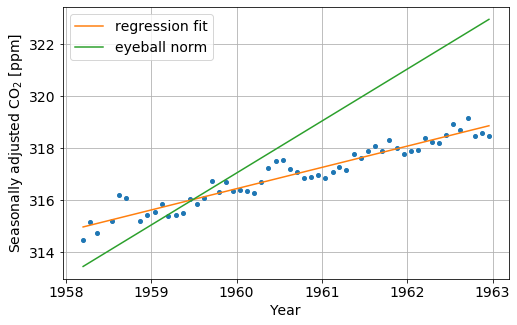

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plot_co2_data(dates_before_early_year, co2_before_early_year, ax=ax)
add_line(dates_before_early_year, slope_early, intercept_early, ax=ax, label="regression fit")
add_line(dates_before_early_year, eyeball_slope_early, eyeball_intercept_early, ax=ax, label="eyeball norm")
ax.legend()


### Make a prediction with the slope from linear regression

In [17]:
predict_year = 2022

prediction_fit_early = predict_co2(
    slope_early,
    intercept_early,
    dates_before_early_year.min(),
    predict_year
)

print(
    f"Predicted CO2 in {predict_year}: {prediction_fit_early:1.2f} [ppm]"
)

Predicted CO2 in 2022: 367.21 [ppm]


## Focus on recent data: the last 5 years

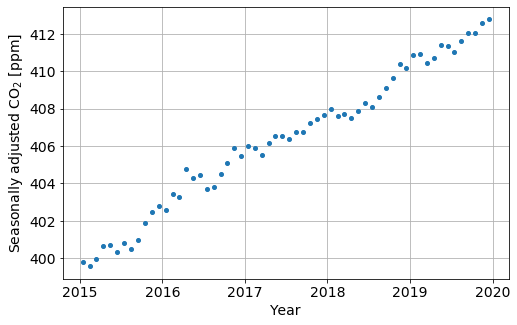

In [18]:
recent_year = 2015
dates_after_recent_year, co2_after_recent_year = get_data_between(year_min=recent_year)
plot_co2_data(dates_after_recent_year, co2_after_recent_year)

In [19]:
w_recent = widgets.interactive(
    widget_fit_co2_data, 
    slope=widgets.FloatSlider(min=0, max=5, step=0.1, value=2),
    intercept=widgets.FloatSlider(min=co2_after_recent_year.min()-1, max=co2_after_recent_year.max()+1, step=0.25),
    year_min=widgets.fixed(recent_year),
    year_max=widgets.fixed(2020),
)
w_recent

interactive(children=(FloatSlider(value=2.0, description='slope', max=5.0), FloatSlider(value=398.56, descript…

In [20]:
slope_recent, intercept_recent, r2, _, _ = stats.linregress(
    dates_after_recent_year  - dates_after_recent_year.min(), co2_after_recent_year 
)
print(
    f"The slope from linear regression is:         {slope_recent:1.2f} ppm/year \n"
    f"and the intercept from linear regression is: {intercept_recent:1.2f} ppm"
)

The slope from linear regression is:         2.56 ppm/year 
and the intercept from linear regression is: 400.08 ppm


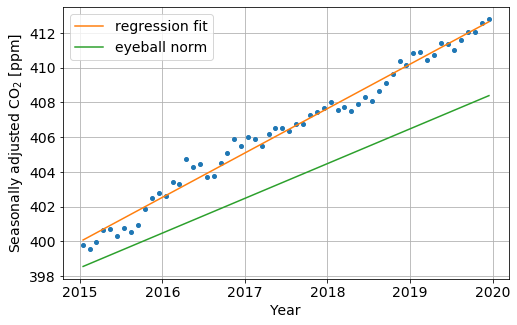

In [21]:
eyeball_slope_recent = w_recent.children[0].value
eyeball_intercept_recent = w_recent.children[1].value

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plot_co2_data(dates_after_recent_year, co2_after_recent_year, ax=ax)
add_line(dates_after_recent_year, slope_recent, intercept_recent, ax=ax, label="regression fit")
add_line(dates_after_recent_year, eyeball_slope_recent, eyeball_intercept_recent, ax=ax, label="eyeball norm")
ax.legend()


### Predict concentration using data from 2015 -- 2020

In [22]:
predict_year = 2022

prediction_fit_recent = predict_co2(
    slope_recent,
    intercept_recent,
    dates_after_recent_year.min(),
    predict_year
)

print(
    f"Predicted CO2 in {predict_year}: {prediction_fit_recent:1.2f} ppm"
)

Predicted CO2 in 2022: 417.87 ppm


## Compare these models

In [23]:
print(
    f"Predicted CO2 in {predict_year} using data from: \n"
    f"  1958 - {early_year}: {prediction_fit_early:1.2f} ppm, with a slope of {slope_early:1.2f} ppm/year \n"
    f"  {recent_year} - 2020: {prediction_fit_recent:1.2f} ppm, with a slope of {slope_recent:1.2f} ppm/year"
)

Predicted CO2 in 2022 using data from: 
  1958 - 1963: 367.21 ppm, with a slope of 0.82 ppm/year 
  2015 - 2020: 417.87 ppm, with a slope of 2.56 ppm/year


## before looking at the next plot(!)

Discuss with your neighbour - why are these so different? 

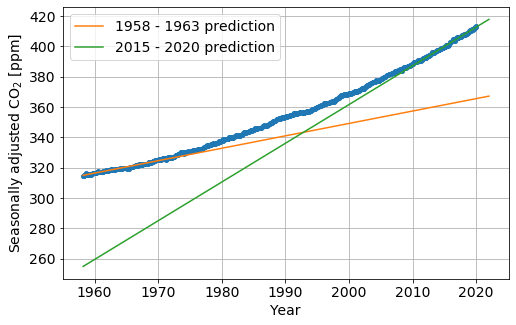

In [24]:
def plot_predictions(xlim=None, ylim=None):
    dates_to_year_predicted = np.hstack([dates, np.r_[predict_year]])

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    plot_co2_data(dates, co2, ax=ax)

    # add predictions to 2022
    add_line(
        dates_to_year_predicted, slope_early, intercept_early, 
        ax=ax, label=f"1958 - {early_year} prediction"
    )

    add_line(
        dates_to_year_predicted, slope_recent, 
        intercept_recent-((dates_after_recent_year.min() - dates.min())*slope_recent), # adjust the intercept to use 1958 as the "zero"
        ax=ax, label=f"{recent_year} - 2020 prediction"
    )
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend()

plot_predictions()

## Discussion:

**Q1:** Within small enough regions, the data follow an approximately linear trend, so a linear model has some predictive power. In the following cell, we have a widget where you can zoom in on the plot. 
- Out to which year would you trust the model built with the data from 1958 - 1963? 
- Where does it start to break down?

**Q2:** How far out would you trust our predictions with data from 2015 - 2020? Would you trust our model to predict CO$_2$ in the year 2050? 

**Q3:** How would you approach building a model to fit all of our data? 



In [25]:
widgets.interactive(
    plot_predictions, 
    xlim=widgets.IntRangeSlider(min=dates.min(), max=predict_year+1, value=[int(dates.min()), predict_year+1], continuous_update=False),
    ylim=widgets.IntRangeSlider(min=300, max=420, value=[300, 420],  continuous_update=False),
   
)

interactive(children=(IntRangeSlider(value=(1958, 2023), continuous_update=False, description='xlim', max=2023…

# Explore further: 

Try expanding the number of years included in each analysis. How many years does it take before a linear model is no longer appropriate?  

# Upcoming topics:

- Assessing quality of fit and the impact of outliers 
- Deriving the solution to the least squares problem
- How do we incorporate data uncertainties into our model?
- How do we fit models which are not linear? 

## For next lecture - compare your fit to a least squares fit
What impact does an outlier have?

In [26]:
np.random.seed(2020)  # set a random seed so we are working with the same data

slope = 1
intercept = 0
n_samples = 10
noise_level = 0.1

x = np.linspace(0, 1, n_samples)
y = slope*x + intercept + noise_level * np.random.randn(n_samples)

In [27]:
def create_outlier(outlier=n_samples-1, offset=0):
    yy = y.copy()
    yy[int(outlier)] = yy[int(outlier)] + offset
    return yy

In [28]:
def plot_data_with_outlier(outlier=n_samples-2, offset=0, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    yy = create_outlier(outlier, offset)
    ax.plot(x, yy, 'o')
    ax.grid(which="both")

In [29]:
def plot_eyeball_norm_outlier(
    outlier=n_samples/2, offset=0., slope=1, intercept=0
):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        
    plot_data_with_outlier(outlier, offset, ax)
    add_line(x, slope, intercept, ax)

In [30]:
w_outlier = widgets.interactive(
    plot_eyeball_norm_outlier, 
    outlier=widgets.IntSlider(min=0, max=n_samples, value=n_samples-2),
    offset=widgets.FloatSlider(min=-5, max=5, value=1),
    slope=widgets.FloatSlider(min=0, max=2, value=0.5),
    intercept=widgets.FloatSlider(min=-1, max=1, value=0),
    
)

w_outlier

interactive(children=(IntSlider(value=8, description='outlier', max=10), FloatSlider(value=1.0, description='o…

In [31]:
widget_outlier = w_outlier.children[0].value
widget_offset = w_outlier.children[1].value
widget_slope = w_outlier.children[2].value
widget_intercept = w_outlier.children[3].value

In [32]:
slope_outlier_fit, intercept_outlier_fit, r2, _, _ = stats.linregress(
    x, create_outlier(widget_outlier, widget_offset)
)
print(
    f"The slope from linear regression is:         {slope_outlier_fit:1.2f} \n"
    f"and the intercept from linear regression is: {intercept_outlier_fit:1.2f}"
)

The slope from linear regression is:         1.49 
and the intercept from linear regression is: -0.20


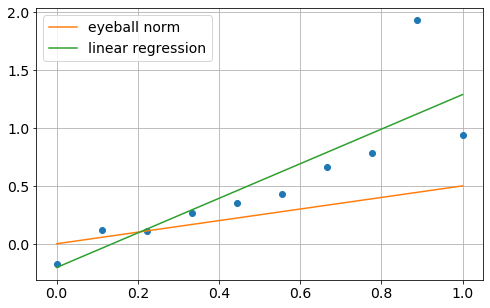

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plot_data_with_outlier(widget_outlier, widget_offset, ax)
add_line(x, widget_slope, widget_intercept, ax, label="eyeball norm")
add_line(x, slope_outlier_fit, intercept_outlier_fit, ax, label="linear regression")
ax.legend()
